import libraries

In [40]:
import os
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore")  # Optional: suppress all warnings

In [ ]:
merged_df = pd.read_csv("../../datasets/raw/10. data for modeling suburb growth/merged_df.csv")

configs

In [ ]:
CSV_PATH = "../../datasets/raw/10. data for modeling suburb growth/merged_df.csv"
SPLIT = "2024-09-01"  # train < SPLIT ; test >= SPLIT
EXOGS = ("ERP_quarterly", "Income_quarterly_med")
ENTITY_COL = "SA2_CODE21"
NAME_COL = "SA2_NAME21"
SEASONAL_PERIODS = 4
MIN_TRAIN = 8
MIN_TEST = 2

OUT_DIR = os.path.join(os.path.dirname(CSV_PATH), "ucm_sa2_outputs")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_METRICS = os.path.join(OUT_DIR, "ucm_sa2_metrics.csv")
OUT_PREDS = os.path.join(OUT_DIR, "ucm_sa2_predictions.csv")

Calculates MAE, RMSE, and R² between actual and predicted values.  

In [24]:
def _metrics(y_true, y_pred):
    y_true = pd.to_numeric(pd.Series(y_true), errors="coerce")
    y_pred = pd.to_numeric(pd.Series(y_pred), errors="coerce")
    m = ~(y_true.isna() | y_pred.isna())
    if m.sum() == 0:
        return np.nan, np.nan, np.nan
    y_true = y_true[m]
    y_pred = y_pred[m]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    return mae, rmse, r2


load and prepare dataset


In [ ]:
merged_df = pd.read_csv(CSV_PATH)

# Validate required columns
need_cols = {"date", "Median", ENTITY_COL, *EXOGS}
missing = [c for c in need_cols if c not in merged_df.columns]
if missing:
    raise KeyError(f"Input CSV missing required columns: {missing}")

merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
merged_df[ENTITY_COL] = merged_df[ENTITY_COL].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(9)

name_map = None
if NAME_COL in merged_df.columns:
    tmp = merged_df[[ENTITY_COL, NAME_COL]].dropna().drop_duplicates(subset=[ENTITY_COL])
    name_map = tmp.set_index(ENTITY_COL)[NAME_COL]

Aggregate Data by SA2 and Date  

In [ ]:
agg_dict = {"Median": "median"}
for ex in EXOGS:
    agg_dict[ex] = "mean"

sa2_daily = (
    merged_df
    .dropna(subset=["date"])
    .groupby([ENTITY_COL, "date"], as_index=False)
    .agg(agg_dict)
    .sort_values([ENTITY_COL, "date"])
    .reset_index(drop=True)
)

Convert to Quarterly Panel Format

In [ ]:
def to_quarterly_panel(df, entity_col=ENTITY_COL, exog_cols=EXOGS):
    need = [entity_col, "date", "Median", *exog_cols]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"DataFrame missing columns: {missing}")

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values([entity_col, "date"]).reset_index(drop=True)

    def _qfill(g):
        g = g.set_index("date").asfreq("3MS").sort_index()
        for c in ["Median", *exog_cols]:
            g[c] = g[c].ffill().bfill()
        return g.reset_index()

    return (
        out.groupby(entity_col, group_keys=False)
        .apply(_qfill)
        .sort_values([entity_col, "date"])
        .reset_index(drop=True)
    )

Fit UCM Model per SA2 Entity

In [ ]:
def evaluate_ucm_per_entity(
    df,
    split_date=SPLIT,
    exog_cols=EXOGS,
    seasonal_periods=SEASONAL_PERIODS,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    entity_col=ENTITY_COL
):
    qdf = to_quarterly_panel(df, entity_col=entity_col, exog_cols=exog_cols)
    split_date = pd.Timestamp(split_date)

    metrics, preds = [], []
    for entity, g in qdf.groupby(entity_col):
        g = g[["date", "Median", *exog_cols]].copy()
        y = g.set_index("date")["Median"]
        X = g.set_index("date")[list(exog_cols)]

        y_tr, y_te = y[y.index < split_date], y[y.index >= split_date]
        X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]

        if len(y_tr) < min_train or len(y_te) < min_test:
            continue

        try:
            mdl = UnobservedComponents(
                endog=y_tr,
                level="local linear trend",
                seasonal=seasonal_periods,
                exog=X_tr
            )
            res = mdl.fit(disp=False)
            fc = res.get_forecast(steps=len(y_te), exog=X_te)
            yhat = fc.predicted_mean

            mae, rmse, r2 = _metrics(y_te, yhat)
            metrics.append({
                entity_col: entity,
                "Model": f"UCM_LLtrend+Season{seasonal_periods}+exog",
                "MAE_Test": mae,
                "RMSE_Test": rmse,
                "R2_Test": r2,
                "Train_n": len(y_tr),
                "Test_n": len(y_te)
            })
            preds.append(pd.DataFrame({
                entity_col: entity,
                "date": y_te.index,
                "Actual": y_te.values,
                "Predicted": yhat.values,
                "Model": "UCM"
            }))
        except Exception as e:
            metrics.append({
                entity_col: entity,
                "Model": f"UCM_LLtrend+Season{seasonal_periods}+exog",
                "MAE_Test": np.nan,
                "RMSE_Test": np.nan,
                "R2_Test": np.nan,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "Error": str(e)
            })

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

    if name_map is not None and not metrics_df.empty:
        metrics_df[NAME_COL] = metrics_df[entity_col].map(name_map)
    if name_map is not None and not preds_df.empty:
        preds_df[NAME_COL] = preds_df[entity_col].map(name_map)

    return metrics_df, preds_df

Run and Save UCM Model Results

In [ ]:
ucm_metrics, ucm_preds = evaluate_ucm_per_entity(
    sa2_daily,
    split_date=SPLIT,
    exog_cols=EXOGS,
    seasonal_periods=SEASONAL_PERIODS,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    entity_col=ENTITY_COL
)

# Output summary
print(f"SA2s evaluated: {ucm_metrics[ENTITY_COL].nunique() if not ucm_metrics.empty else 0}")
print("Sample metrics:")
print(ucm_metrics.head(10).to_string(index=False))

print("\nSample predictions:")
print(ucm_preds.head(10).to_string(index=False))

# Save to CSV
ucm_metrics.to_csv(OUT_METRICS, index=False)
ucm_preds.to_csv(OUT_PREDS, index=False)

print(f"\nSaved metrics to: {OUT_METRICS}")
print(f"Saved predictions to: {OUT_PREDS}")

SA2s evaluated: 138
Sample metrics:
SA2_CODE21                    Model  MAE_Test  RMSE_Test    R2_Test  Train_n  Test_n                    SA2_NAME21
 201011002 UCM_LLtrend+Season4+exog  7.316142   7.696191  -9.661643       30       3                      Ballarat
 201011005 UCM_LLtrend+Season4+exog  9.482263  10.018623  -2.249479       30       3                     Buninyong
 201011006 UCM_LLtrend+Season4+exog  4.008614   4.377210   0.000000       30       3                     Delacombe
 201011008 UCM_LLtrend+Season4+exog  7.611203   8.738137   0.000000       30       3       Wendouree - Miners Rest
 202011018 UCM_LLtrend+Season4+exog 12.602767  12.659156  -8.615254       30       3                       Bendigo
 202011021 UCM_LLtrend+Season4+exog  4.191054   4.294268   0.723389       30       3     Flora Hill - Spring Gully
 202011022 UCM_LLtrend+Season4+exog  6.274622   6.979685   0.269260       30       3 Kangaroo Flat - Golden Square
 202021027 UCM_LLtrend+Season4+exog  8.26139

Visualise UCM Forecasts for Sample SA2s

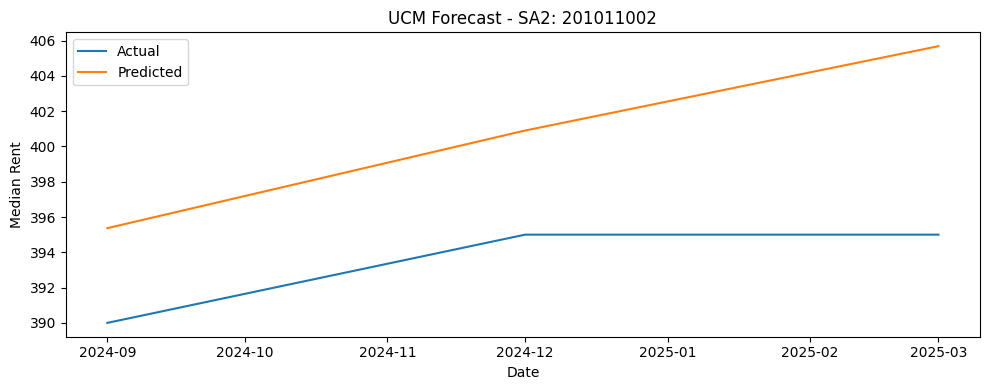

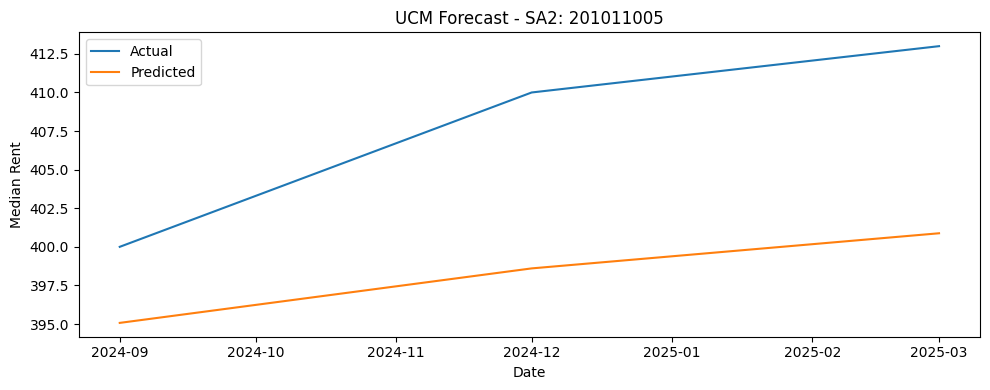

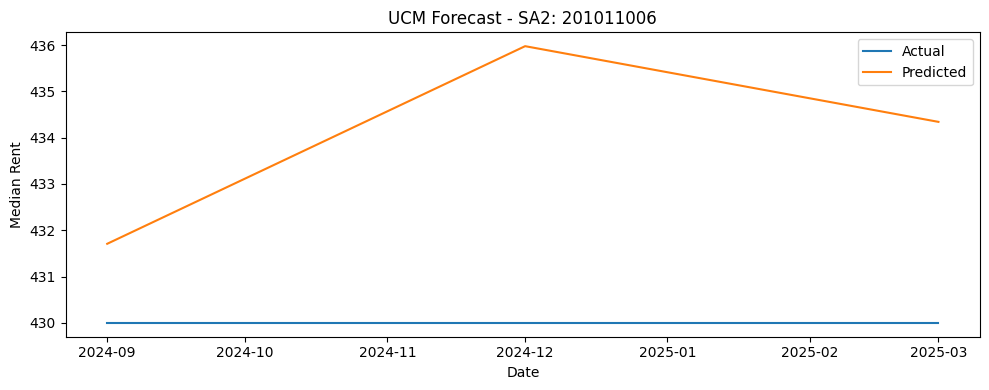

In [ ]:
example_sa2s = ucm_preds[ENTITY_COL].dropna().unique()[:3]  # first 3 available
for sa2 in example_sa2s:
    subset = ucm_preds[ucm_preds[ENTITY_COL] == sa2]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['date'], subset['Actual'], label="Actual")
    plt.plot(subset['date'], subset['Predicted'], label="Predicted")
    plt.title(f"UCM Forecast - SA2: {sa2}")
    plt.xlabel("Date")
    plt.ylabel("Median Rent")
    plt.legend()
    plt.tight_layout()
    plt.show()

ARIMA Model Configuration

In [ ]:
CSV_PATH = "../../datasets/raw/10. data for modeling suburb growth/merged_df.csv"
SPLIT = "2024-09-01"  

ENTITY_COL = "SA2_CODE21"
NAME_COL   = "SA2_NAME21"

BASE_EXOGS = ("ERP_quarterly", "Income_quarterly_med")
EXOGS = (*BASE_EXOGS, "ERPxIncome")  # interaction term

P_GRID = (0, 1, 2, 3)
Q_GRID = (0, 1, 2, 3)

MIN_TRAIN = 12
MIN_TEST = 2
USE_LOG = True

OUT_DIR = os.path.join(os.path.dirname(CSV_PATH), "arima_new_sa2_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

OUT_METRICS = os.path.join(OUT_DIR, "arima_new_sa2_metrics.csv")
OUT_PREDS   = os.path.join(OUT_DIR, "arima_new_sa2_predictions.csv")


Load & Preprocess Data for ARIMA

In [ ]:
merged_df = pd.read_csv(CSV_PATH)

need_cols = {"date", "Median", ENTITY_COL, *BASE_EXOGS}
missing = [c for c in need_cols if c not in merged_df.columns]
if missing:
    raise KeyError(f"Input CSV missing required columns: {missing}")

merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
merged_df[ENTITY_COL] = merged_df[ENTITY_COL].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(9)

# Optional: build code -> name map
name_map = None
if NAME_COL in merged_df.columns:
    nm = merged_df[[ENTITY_COL, NAME_COL]].dropna().drop_duplicates(subset=[ENTITY_COL])
    name_map = nm.set_index(ENTITY_COL)[NAME_COL]


Aggregate Data by SA2 and Date

In [ ]:
agg_dict = {"Median": "median"}
for ex in BASE_EXOGS:
    agg_dict[ex] = "mean"

sa2_daily = (
    merged_df
    .dropna(subset=["date"])
    .groupby([ENTITY_COL, "date"], as_index=False)
    .agg(agg_dict)
    .sort_values([ENTITY_COL, "date"])
    .reset_index(drop=True)
)


Convert to Quarterly Panel

In [ ]:
def to_quarterly_panel(df, entity_col=ENTITY_COL, base_exogs=BASE_EXOGS):
    need = [entity_col, "date", "Median", *base_exogs]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"DataFrame missing columns: {missing}")

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.sort_values([entity_col, "date"]).reset_index(drop=True)

    def _qfill(g):
        g = g.set_index("date").asfreq("3MS").sort_index()
        for c in ["Median", *base_exogs]:
            g[c] = g[c].ffill().bfill()
        if set(base_exogs).issuperset({"ERP_quarterly", "Income_quarterly_med"}):
            g["ERPxIncome"] = g["ERP_quarterly"] * g["Income_quarterly_med"]
        else:
            ex = list(base_exogs)
            g["ERPxIncome"] = g[ex[0]] * g[ex[1]] if len(ex) >= 2 else np.nan
        return g.reset_index()

    return (
        out.groupby(entity_col, group_keys=False)
           .apply(_qfill)
           .sort_values([entity_col, "date"])
           .reset_index(drop=True)
    )


Grid Search for Best ARIMA(p,0,q) Model

In [ ]:
def arima_new_best(y_tr, X_tr, p_grid=P_GRID, q_grid=Q_GRID):
    best = {"aic": np.inf, "order": None, "res": None}
    for p in p_grid:
        for q in q_grid:
            try:
                mdl = ARIMA(endog=y_tr, exog=X_tr, order=(p, 0, q))
                res = mdl.fit()
                if np.isfinite(res.aic) and res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p, 0, q), "res": res}
            except Exception:
                continue
    return best


Evaluate ARIMA Models for Each SA2

In [ ]:
def evaluate_arima_new_sa2(
    df,
    split_date=SPLIT,
    entity_col=ENTITY_COL,
    exog_cols=EXOGS,
    base_exogs=BASE_EXOGS,
    p_grid=P_GRID,
    q_grid=Q_GRID,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    use_log=USE_LOG
):
    qdf = to_quarterly_panel(df, entity_col=entity_col, base_exogs=base_exogs)
    split_date = pd.Timestamp(split_date)

    metrics, preds = [], []

    for sa2, g in qdf.groupby(entity_col):
        g = g[["date", "Median", *exog_cols]].copy().set_index("date").sort_index()
        g = g.ffill().bfill()

        y = g["Median"]
        X = g[list(exog_cols)]

        y_tr, y_te = y[y.index < split_date], y[y.index >= split_date]
        X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]

        if len(y_tr) < min_train or len(y_te) < min_test:
            continue

        try:
            y_tr_fit = np.log(y_tr.clip(lower=1.0)) if use_log else y_tr
            best = arima_new_best(y_tr_fit, X_tr, p_grid=p_grid, q_grid=q_grid)

            if best["res"] is None:
                raise RuntimeError("No converged ARIMA-new model for this SA2.")

            fc = best["res"].forecast(steps=len(y_te), exog=X_te)
            yhat_log_or_lin = pd.Series(fc, index=y_te.index)
            yhat = np.exp(yhat_log_or_lin.values) if use_log else yhat_log_or_lin.values

            mae, rmse, r2 = _metrics(y_te, yhat)

            metrics.append({
                entity_col: sa2,
                "Model": "ARIMA-new",
                "MAE_Test": mae,
                "RMSE_Test": rmse,
                "R2_Test": r2,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "AIC": best["aic"],
                "Order": best["order"]
            })

            preds.append(pd.DataFrame({
                entity_col: sa2,
                "date": y_te.index,
                "Actual": y_te.values,
                "Predicted": yhat,
                "Model": "ARIMA-new"
            }))

        except Exception as e:
            metrics.append({
                entity_col: sa2,
                "Model": "ARIMA-new",
                "MAE_Test": np.nan,
                "RMSE_Test": np.nan,
                "R2_Test": np.nan,
                "Train_n": len(y_tr),
                "Test_n": len(y_te),
                "AIC": np.inf,
                "Error": str(e)
            })

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

    if name_map is not None and not metrics_df.empty:
        metrics_df[NAME_COL] = metrics_df[entity_col].map(name_map)
    if name_map is not None and not preds_df.empty:
        preds_df[NAME_COL] = preds_df[entity_col].map(name_map)

    return metrics_df, preds_df


Run ARIMA Evaluation and Save Results

In [ ]:
arima_metrics, arima_preds = evaluate_arima_new_sa2(
    sa2_daily,
    split_date=SPLIT,
    entity_col=ENTITY_COL,
    exog_cols=EXOGS,
    base_exogs=BASE_EXOGS,
    p_grid=P_GRID,
    q_grid=Q_GRID,
    min_train=MIN_TRAIN,
    min_test=MIN_TEST,
    use_log=USE_LOG
)

print(f"SA2s evaluated: {arima_metrics[ENTITY_COL].nunique() if not arima_metrics.empty else 0}")
print("Sample metrics:\n", arima_metrics.head(10).to_string(index=False))
print("\nSample predictions:\n", arima_preds.head(10).to_string(index=False))

arima_metrics.to_csv(OUT_METRICS, index=False)
arima_preds.to_csv(OUT_PREDS, index=False)

print(f"\nSaved metrics to: {OUT_METRICS}")
print(f"Saved predictions to: {OUT_PREDS}")


SA2s evaluated: 138
Sample metrics:
 SA2_CODE21     Model  MAE_Test  RMSE_Test     R2_Test  Train_n  Test_n         AIC     Order                    SA2_NAME21
 201011002 ARIMA-new  7.406074   8.232607  -11.199646       30       3 -166.201138 (2, 0, 2)                      Ballarat
 201011005 ARIMA-new 16.123495  17.175739   -8.550554       30       3 -156.109233 (1, 0, 0)                     Buninyong
 201011006 ARIMA-new  9.619885  10.113367    0.000000       30       3 -167.785904 (1, 0, 0)                     Delacombe
 201011008 ARIMA-new  3.896449   4.342046    0.000000       30       3 -187.249438 (2, 0, 3)       Wendouree - Miners Rest
 202011018 ARIMA-new 30.121509  30.812116  -55.963190       30       3 -190.482281 (1, 0, 0)                       Bendigo
 202011021 ARIMA-new 15.915080  20.109218   -5.065710       30       3 -160.331099 (1, 0, 1)     Flora Hill - Spring Gully
 202011022 ARIMA-new  5.868950   6.703180    0.326011       30       3 -167.692014 (2, 0, 1) Kangaroo 

Visualize ARIMA Forecasts

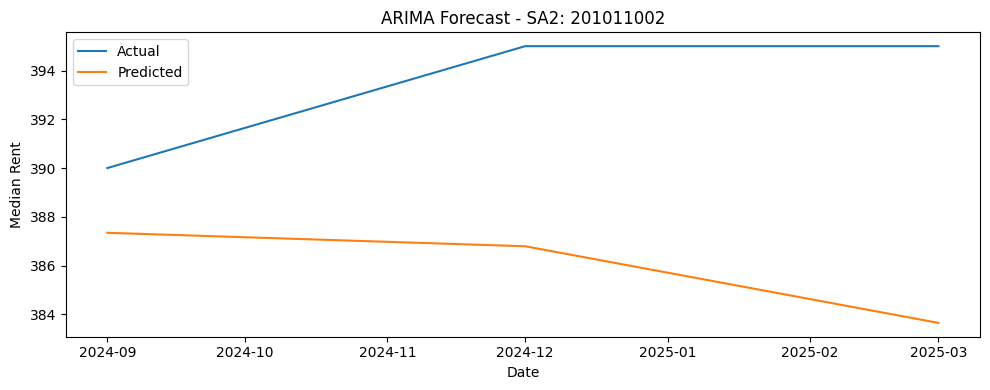

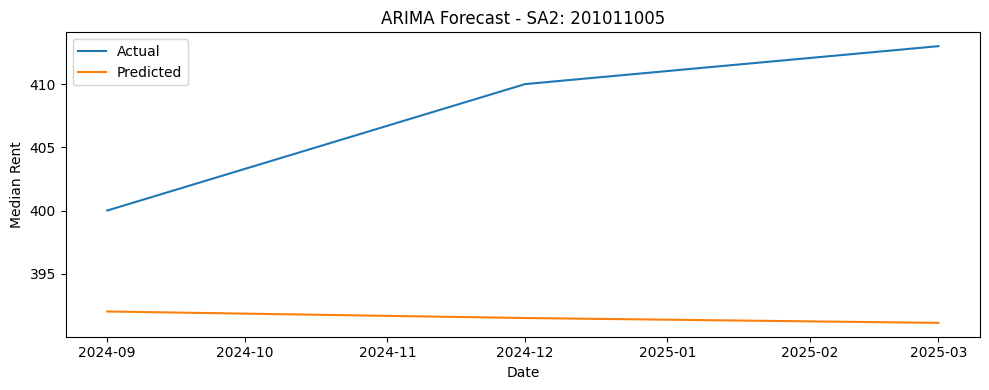

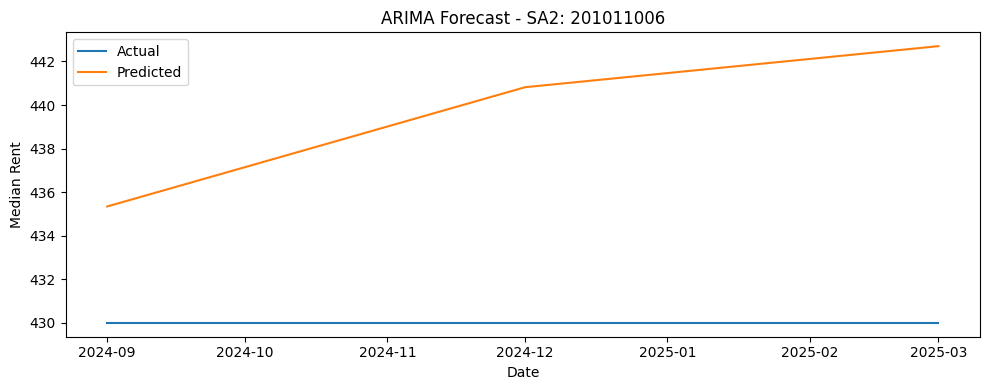

In [42]:
example_sa2s = arima_preds[ENTITY_COL].dropna().unique()[:3]
for sa2 in example_sa2s:
    subset = arima_preds[arima_preds[ENTITY_COL] == sa2]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['date'], subset['Actual'], label="Actual")
    plt.plot(subset['date'], subset['Predicted'], label="Predicted")
    plt.title(f"ARIMA Forecast - SA2: {sa2}")
    plt.xlabel("Date")
    plt.ylabel("Median Rent")
    plt.legend()
    plt.tight_layout()
    plt.show()


Display Selected ARIMA Orders per SA2

In [ ]:
arima_orders = (
    arima_metrics.loc[arima_metrics["Order"].notna(), ["SA2_NAME21", "Order", "AIC", "RMSE_Test", "MAE_Test", "R2_Test"]]
    .sort_values(["SA2_NAME21"])
)
arima_orders.head(20)


,SA2_NAME21,Order,AIC,RMSE_Test,MAE_Test,R2_Test
49,Abbotsford,"(2, 0, 1)",-150.727194,4.307644,3.960654,-2.976242
41,Albert Park,"(1, 0, 0)",-110.502382,55.589576,54.091857,-282.793964
28,Alphington - Fairfield,"(1, 0, 0)",-111.631324,43.590421,42.263269,-20.376404
118,Altona,"(2, 0, 2)",-171.252968,31.636443,30.484753,0.000000
46,Armadale,"(3, 0, 0)",-119.761146,29.440658,24.749284,-5.240617
111,Ashwood - Chadstone,"(1, 0, 1)",-150.201915,69.274877,66.259498,-52.988846
85,Avondale Heights,"(1, 0, 0)",-174.709160,13.655994,13.592108,-7.391878
20,Bairnsdale,"(2, 0, 0)",-132.726069,56.872461,52.153074,-35.387865
0,Ballarat,"(2, 0, 2)",-166.201138,8.232607,7.406074,-11.199646
53,Balwyn,"(2, 0, 0)",-136.807846,55.125944,53.793958,0.000000


Portfolio Summary

In [ ]:
def portfolio_np_summary(metrics_df, label):
    sub = metrics_df[['MAE_Test', 'RMSE_Test', 'R2_Test']].dropna(how='all')
    out = {
        'count': int(len(sub)),
        'MAE_mean': np.float64(sub['MAE_Test'].mean()) if not sub.empty else np.float64('nan'),
        'RMSE_mean': np.float64(sub['RMSE_Test'].mean()) if not sub.empty else np.float64('nan'),
        'R2_mean': np.float64(sub['R2_Test'].mean()) if not sub.empty else np.float64('nan'),
    }
    print(f"{label} : {out}")

output

In [ ]:
portfolio_np_summary(ucm_metrics, "UCM")
portfolio_np_summary(arima_metrics, "ARIMA-new")

UCM : {'count': 138, 'MAE_mean': 16.98230681648801, 'RMSE_mean': 18.957777168967837, 'R2_mean': -37.90117635124207}
ARIMA-new : {'count': 138, 'MAE_mean': 26.253189249299385, 'RMSE_mean': 28.646669657388298, 'R2_mean': -91.66172734611638}
